In [1]:
#https://blog.csdn.net/fangchenglia/article/details/125725093
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from matplotlib import pyplot as plt
import os
import time
from MazeEnv import MazeEnv
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# env = gym.make('Pendulum-v1').unwrapped



'''Pendulum环境状态特征是三个，杆子的sin(角度)、cos（角度）、角速度，（状态是无限多个，因为连续），动作值是力矩，限定在[-2,2]之间的任意的小数，所以是连续的（动作也是无限个）'''
# state_number=env.observation_space.shape[0]
# action_number=env.action_space.shape[0]
# max_action = env.action_space.high[0]
# min_action = env.action_space.low[0]


torch.manual_seed(0)#如果你觉得定了随机种子不能表达代码的泛化能力，你可以把这两行注释掉
# env.seed(0) 
RENDER=False
ITER_MAX = 2000
EP_MAX = 500
EP_LEN = 40
GAMMA = 0.99
A_LR = 0.0001
C_LR = 0.0003
BATCH = 128
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
DEVICE = "cuda"
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better
][1]        # choose the method for optimization
Switch=0
'''由于PPO也是基于A-C框架，所以我把PPO的编写分为两部分，PPO的第一部分 Actor'''
'''PPO的第一步  编写A-C框架的网络，先编写actor部分的actor网络，actor的网络有新与老两个网络'''

N = 5
M = 5
NUM_ENV = 50

env = MazeEnv(N, M)
state_number = env.get_n_states()
action_number = env.get_n_actions()
max_action = 0.99999
min_action = -0.99999
envs = [MazeEnv(N, M) for i in range(NUM_ENV)]


class ActorNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_1 = nn.Linear(hidden_dim, output_dim)
        self.fc3_2 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        mean=torch.tanh(self.fc3_1(x))#输出概率分布的均值mean-1~1   TODO
        std=F.softplus(self.fc3_2(x))#softplus激活函数的值域>0
        return mean, std
    
class CriticNet(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(CriticNet,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value 
    
class Actor():
    def __init__(self):
        self.old_pi,self.new_pi=ActorNet(state_number,action_number).to(DEVICE),ActorNet(state_number,action_number).to(DEVICE)#这只是均值mean
        self.optimizer=torch.optim.Adam(self.new_pi.parameters(),lr=A_LR,eps=1e-5)
    '''第二步 编写根据状态选择动作的函数'''
    def choose_action(self,s):
        inputstate = torch.tensor(s, dtype=torch.float32, device=DEVICE)
        mean,std=self.old_pi(inputstate)
        dist = torch.distributions.Normal(mean, std)
        action=dist.sample()
        action=torch.clamp(action,min_action,max_action)
        action_logprob=dist.log_prob(action) # 
        return action.detach().cpu().numpy(),action_logprob.detach().cpu().numpy()
    
    def choose_action2(self,s):
        inputstate = torch.tensor(s, dtype=torch.float32, device=DEVICE)
        mean,std=self.old_pi(inputstate) # TODO
        print(mean, std)
        dist = torch.distributions.Normal(mean, std)
        action=mean
        action=torch.clamp(action,min_action,max_action)
        action_logprob=dist.log_prob(action)
        return action.detach().cpu.numpy(),action_logprob.detach().cpu.numpy()
    
    '''第四步  actor网络有两个策略（更新old策略）————————把new策略的参数赋给old策略'''
    def update_oldpi(self):
        self.old_pi.load_state_dict(self.new_pi.state_dict())
    '''第六步 编写actor网络的学习函数，采用PPO2，即OpenAI推出的clip形式公式'''
    def learn(self,bs,ba,adv,bap): #buffer_s, buffer_a, advantage, buffer_a_logp
        bs = torch.tensor(bs, dtype=torch.float32, device=DEVICE)
        ba = torch.tensor(ba, dtype=torch.float32, device=DEVICE)
        adv = torch.tensor(adv, dtype=torch.float32, device=DEVICE)
        bap = torch.tensor(bap, dtype=torch.float32, device=DEVICE)
        for _ in range(A_UPDATE_STEPS):
            mean, std = self.new_pi(bs)
            dist_new=torch.distributions.Normal(mean, std)
            action_new_logprob=dist_new.log_prob(ba)
            ratio=torch.exp(action_new_logprob - bap.detach())
            surr1 = ratio * adv
            surr2 = torch.clamp(ratio, 1 - METHOD['epsilon'], 1 + METHOD['epsilon']) * adv
            loss = -torch.min(surr1, surr2)
            loss=loss.mean()
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.new_pi.parameters(), 0.5)
            self.optimizer.step()
class Critic():
    def __init__(self):
        self.critic_v=CriticNet(state_number,1).to(DEVICE) #改网络输入状态，生成一个V值
        self.optimizer = torch.optim.Adam(self.critic_v.parameters(), lr=C_LR,eps=1e-5)
        self.lossfunc = nn.MSELoss()
    '''第三步  编写评定动作价值的函数'''
    def get_v(self,s):
        inputstate = torch.tensor(s, dtype=torch.float32, device=DEVICE)
        return self.critic_v(inputstate)
    '''第五步  计算优势——————advantage，后面发现第五步计算出来的adv可以与第七步合为一体，所以这里的代码注释了，但是，计算优势依然算是可以单独拎出来的一个步骤'''
    # def get_adv(self,bs,br):
    #     reality_v=torch.FloatTensor(br)
    #     v=self.get_v(bs)
    #     adv=(reality_v-v).detach()
    #     return adv
    '''第七步  编写actor-critic的critic部分的learn函数，td-error的计算代码（V现实减去V估计就是td-error）'''
    def learn(self,bs,br):
        bs = torch.tensor(bs, dtype=torch.float32, device=DEVICE)
        reality_v = torch.tensor(br, dtype=torch.float32, device=DEVICE)
        for _ in range(C_UPDATE_STEPS):
            v=self.get_v(bs)
            td_e = self.lossfunc(reality_v, v)
            self.optimizer.zero_grad()
            td_e.backward()
            nn.utils.clip_grad_norm_(self.critic_v.parameters(), 0.5) #是否需要需要考虑
            self.optimizer.step()
        return (reality_v-v).detach()
       
class MyTime():
     
    def __init__(self):
        self.start_time = 0
        
    def start(self):
        self.start_time = time.time()
        
    def end(self, text):
        run_time = time.time() - self.start_time
#         print(f"{text} {run_time:.4f} s")
        
def train():
    print('PPO2训练中...')
    actor=Actor()
    critic=Critic()
    my_time = MyTime()
    
    all_ep_r = []
    for iteration in range(ITER_MAX): # iteration
        b_s, b_a, b_r,b_a_logp, d_r = [], [], [], [], []
        reward_totle=0
        done_totle=0
        
        my_time.start()
        for episode in range(EP_MAX//NUM_ENV):
            buffer_s, buffer_a, buffer_r, buffer_a_logp , discounted_r = [], [], [],[], []
            
                
            for timestep in range(EP_LEN):
                
                buffer_s_s, buffer_a_s, buffer_r_s, buffer_a_logp_s, discounted_r_s = [], [], [],[], []
                observations = []
                dones = []
                for i in range(NUM_ENV):
                    observations.append(envs[i].reset()) #环境重置
                    dones.append(False)
                    buffer_s_s.append([])
                    buffer_a_s.append([])
                    buffer_r_s.append([])
                    buffer_a_logp_s.append([])
                    discounted_r_s.append([])
                
#                 if RENDER:
#                     env.render()

                my_time.start()
                action,action_logprob=actor.choose_action(observations)  
                my_time.end("action")

                
                my_time.start()
                for i in range(NUM_ENV):
                    if(dones[i]): 
                        continue
                    observation_, reward, done, info = envs[i].step(action[i])
                    
                    buffer_s_s[i].append(observations[i])
                    buffer_a_s[i].append(action[i])
                    buffer_r_s[i].append(reward)
                    buffer_a_logp_s[i].append(action_logprob[i])

                    observations[i]=observation_
                    reward_totle+=reward  

                    if(done):
                        done_totle += 1
                        dones[i] = True
                my_time.end("step")
                
            for i in range(NUM_ENV):
                if(dones[i]):
                    v_observation_ = torch.tensor([1e-8])
                else:
                    v_observation_ = critic.get_v(observations[i])
                    
                for reward in buffer_r_s[i][::-1]:
                    v_observation_ = reward + GAMMA * v_observation_
                    discounted_r_s[i].append(v_observation_.detach().cpu().numpy())   # 没有转成A
                discounted_r_s[i].reverse()
                b_s += buffer_s_s[i]
                b_a += buffer_a_s[i]
                b_r += buffer_r_s[i]
                b_a_logp += buffer_a_logp_s[i]
                d_r += discounted_r_s[i]
            
            
        my_time.end("simulation")
            
        my_time.start()
        
        d_r = torch.tensor(d_r, dtype=torch.float32)
        d_r = (d_r - d_r.mean()) / (d_r.std() + 1e-5) 
        bs, ba, dr, bap = np.vstack(b_s), np.vstack(b_a), np.array(d_r),np.vstack(b_a_logp)

        for _ in range(10):
            msk = np.random.rand(len(bs)) < 0.5
            
            advantage=critic.learn(bs[msk],dr[msk])#critic部分更新
            actor.learn(bs[msk],ba[msk],advantage,bap[msk])#actor部分更新
            
        actor.update_oldpi()  # pi-new的参数赋给pi-old
        # critic.learn(bs,br)
        my_time.end("learn")
            
        if iteration == 0:
            all_ep_r.append(reward_totle)
        else:
#             all_ep_r.append(all_ep_r[-1] * 0.9 + reward_totle * 0.1)
            all_ep_r.append(reward_totle)
            
        print("\rIter: {} |rewards: {} | dones: {}".format(iteration, round(reward_totle/EP_MAX,4), round(done_totle/EP_MAX,4)), end="\n")
        #保存神经网络参数
        if (iteration+1) % 50 == 0 and iteration >= 0:#保存神经网络参数
            save_data = {'net': actor.old_pi.state_dict(), 'opt': actor.optimizer.state_dict(), 'i': episode}
            torch.save(save_data, "./model/PPO2_model_actor.pth")
            save_data = {'net': critic.critic_v.state_dict(), 'opt': critic.optimizer.state_dict(), 'i': episode}
            torch.save(save_data, "./model/PPO2_model_critic.pth")
            plt.plot(np.arange(len(all_ep_r)), all_ep_r)
            plt.xlabel('Episode')
            plt.ylabel('Moving averaged episode reward')
            plt.savefig("reward.jpg")
    
    env.close()
    plt.plot(np.arange(len(all_ep_r)), all_ep_r)
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.show()


/usr/local/lib/python3.6/dist-packages/gym/core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [ ]:
train()

PPO2训练中...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:248: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 0 |rewards: -20.5841 | dones: 0.04
Iter: 1 |rewards: -11.7618 | dones: 0.08
Iter: 2 |rewards: -4.3518 | dones: 0.122
Iter: 3 |rewards: -1.1602 | dones: 0.128
Iter: 4 |rewards: 0.8664 | dones: 0.126
Iter: 5 |rewards: 2.6547 | dones: 0.146
Iter: 6 |rewards: 2.2265 | dones: 0.122
Iter: 7 |rewards: 7.2077 | dones: 0.196
Iter: 8 |rewards: 6.4619 | dones: 0.18
Iter: 9 |rewards: 11.0564 | dones: 0.254
Iter: 10 |rewards: 9.6784 | dones: 0.232
Iter: 11 |rewards: 12.8651 | dones: 0.284
Iter: 12 |rewards: 15.3568 | dones: 0.33
Iter: 13 |rewards: 14.8001 | dones: 0.312
Iter: 14 |rewards: 14.5781 | dones: 0.316
Iter: 15 |rewards: 9.1578 | dones: 0.224
Iter: 16 |rewards: 12.2528 | dones: 0.27
Iter: 17 |rewards: 12.2162 | dones: 0.264
Iter: 18 |rewards: 18.0215 | dones: 0.354
Iter: 19 |rewards: 18.5764 | dones: 0.37
Iter: 20 |rewards: 16.9059 | dones: 0.34
Iter: 21 |rewards: 20.5161 | dones: 0.392
Iter: 22 |rewards: 18.4504 | dones: 0.362
Iter: 23 |rewards: 18.7999 | dones: 0.366
Iter: 24 |rewa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 50 |rewards: 16.3328 | dones: 0.328
Iter: 51 |rewards: 15.8364 | dones: 0.318
Iter: 52 |rewards: 17.3576 | dones: 0.338
Iter: 53 |rewards: 17.0135 | dones: 0.334
Iter: 54 |rewards: 12.0815 | dones: 0.248
Iter: 55 |rewards: 13.8462 | dones: 0.28
Iter: 56 |rewards: 12.9039 | dones: 0.264
Iter: 57 |rewards: 12.4743 | dones: 0.254
Iter: 58 |rewards: 17.0442 | dones: 0.348
Iter: 59 |rewards: 13.0143 | dones: 0.28
Iter: 60 |rewards: 16.7646 | dones: 0.328
Iter: 61 |rewards: 18.6537 | dones: 0.356
Iter: 62 |rewards: 18.864 | dones: 0.36
Iter: 63 |rewards: 20.8845 | dones: 0.392
Iter: 64 |rewards: 22.1852 | dones: 0.41
Iter: 65 |rewards: 19.4225 | dones: 0.364
Iter: 66 |rewards: 20.881 | dones: 0.388
Iter: 67 |rewards: 24.9865 | dones: 0.456
Iter: 68 |rewards: 21.981 | dones: 0.404
Iter: 69 |rewards: 24.0726 | dones: 0.44
Iter: 70 |rewards: 26.0211 | dones: 0.468
Iter: 71 |rewards: 23.4748 | dones: 0.428
Iter: 72 |rewards: 24.8519 | dones: 0.45
Iter: 73 |rewards: 20.0699 | dones: 0.37
It

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 100 |rewards: 22.5928 | dones: 0.408
Iter: 101 |rewards: 19.5408 | dones: 0.352
Iter: 102 |rewards: 25.4347 | dones: 0.456
Iter: 103 |rewards: 23.0374 | dones: 0.412
Iter: 104 |rewards: 21.1962 | dones: 0.382
Iter: 105 |rewards: 20.115 | dones: 0.37
Iter: 106 |rewards: 24.2725 | dones: 0.432
Iter: 107 |rewards: 19.6591 | dones: 0.36
Iter: 108 |rewards: 17.3281 | dones: 0.322
Iter: 109 |rewards: 25.062 | dones: 0.448
Iter: 110 |rewards: 26.1645 | dones: 0.464
Iter: 111 |rewards: 24.5879 | dones: 0.44
Iter: 112 |rewards: 24.5226 | dones: 0.438
Iter: 113 |rewards: 19.6326 | dones: 0.35
Iter: 114 |rewards: 25.5172 | dones: 0.45
Iter: 115 |rewards: 23.7052 | dones: 0.416
Iter: 116 |rewards: 22.1499 | dones: 0.39
Iter: 117 |rewards: 24.2458 | dones: 0.426
Iter: 118 |rewards: 23.5467 | dones: 0.408
Iter: 119 |rewards: 23.7851 | dones: 0.414
Iter: 120 |rewards: 22.469 | dones: 0.4
Iter: 121 |rewards: 22.9717 | dones: 0.41
Iter: 122 |rewards: 23.1008 | dones: 0.406
Iter: 123 |rewards: 22.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 200 |rewards: 21.8242 | dones: 0.358
Iter: 201 |rewards: 25.4548 | dones: 0.42
Iter: 202 |rewards: 25.4418 | dones: 0.416
Iter: 203 |rewards: 22.7203 | dones: 0.372
Iter: 204 |rewards: 25.275 | dones: 0.416
Iter: 205 |rewards: 26.3323 | dones: 0.432
Iter: 206 |rewards: 25.471 | dones: 0.422
Iter: 207 |rewards: 24.8078 | dones: 0.408
Iter: 208 |rewards: 27.0158 | dones: 0.442
Iter: 209 |rewards: 25.4467 | dones: 0.418
Iter: 210 |rewards: 27.1127 | dones: 0.442
Iter: 211 |rewards: 22.8275 | dones: 0.374
Iter: 212 |rewards: 23.4014 | dones: 0.384
Iter: 213 |rewards: 27.7454 | dones: 0.456
Iter: 214 |rewards: 27.3811 | dones: 0.448
Iter: 215 |rewards: 25.8955 | dones: 0.422
Iter: 216 |rewards: 23.3274 | dones: 0.378
Iter: 217 |rewards: 25.3096 | dones: 0.414
Iter: 218 |rewards: 23.4275 | dones: 0.382
Iter: 219 |rewards: 25.6119 | dones: 0.418
Iter: 220 |rewards: 24.7395 | dones: 0.402
Iter: 221 |rewards: 26.489 | dones: 0.43
Iter: 222 |rewards: 23.9799 | dones: 0.388
Iter: 223 |rewar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 250 |rewards: 10.6316 | dones: 0.168
Iter: 251 |rewards: 9.612 | dones: 0.152
Iter: 252 |rewards: 9.2846 | dones: 0.15
Iter: 253 |rewards: 11.7635 | dones: 0.186
Iter: 254 |rewards: 13.3502 | dones: 0.214
Iter: 255 |rewards: 11.955 | dones: 0.194
Iter: 256 |rewards: 10.2886 | dones: 0.17
Iter: 257 |rewards: 10.0365 | dones: 0.172
Iter: 258 |rewards: 10.7753 | dones: 0.182
Iter: 259 |rewards: 15.7912 | dones: 0.26
Iter: 260 |rewards: 12.3187 | dones: 0.206
Iter: 261 |rewards: 18.7171 | dones: 0.304
Iter: 262 |rewards: 17.2161 | dones: 0.282
Iter: 263 |rewards: 20.4218 | dones: 0.336
Iter: 264 |rewards: 21.4218 | dones: 0.348
Iter: 265 |rewards: 20.3046 | dones: 0.326
Iter: 266 |rewards: 22.4583 | dones: 0.368
Iter: 267 |rewards: 22.3089 | dones: 0.362
Iter: 268 |rewards: 18.3371 | dones: 0.3
Iter: 269 |rewards: 19.8914 | dones: 0.332
Iter: 270 |rewards: 15.2377 | dones: 0.254
Iter: 271 |rewards: 19.4243 | dones: 0.316
Iter: 272 |rewards: 17.3566 | dones: 0.286
Iter: 273 |rewards: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 300 |rewards: 24.9863 | dones: 0.422
Iter: 301 |rewards: 26.3212 | dones: 0.44
Iter: 302 |rewards: 21.9958 | dones: 0.374
Iter: 303 |rewards: 22.2952 | dones: 0.384
Iter: 304 |rewards: 24.9082 | dones: 0.42
Iter: 305 |rewards: 25.7274 | dones: 0.428
Iter: 306 |rewards: 24.5354 | dones: 0.41
Iter: 307 |rewards: 26.815 | dones: 0.442
Iter: 308 |rewards: 25.5555 | dones: 0.42
Iter: 309 |rewards: 26.5664 | dones: 0.432
Iter: 310 |rewards: 24.7329 | dones: 0.4
Iter: 311 |rewards: 25.1976 | dones: 0.418
Iter: 312 |rewards: 25.1662 | dones: 0.414
Iter: 313 |rewards: 24.7885 | dones: 0.406
Iter: 314 |rewards: 27.1385 | dones: 0.436
Iter: 315 |rewards: 23.2301 | dones: 0.376
Iter: 316 |rewards: 25.5031 | dones: 0.414
Iter: 317 |rewards: 26.2657 | dones: 0.434
Iter: 318 |rewards: 28.8458 | dones: 0.466
Iter: 319 |rewards: 26.2684 | dones: 0.424
Iter: 320 |rewards: 24.4112 | dones: 0.398
Iter: 321 |rewards: 22.0604 | dones: 0.362
Iter: 322 |rewards: 25.2023 | dones: 0.41
Iter: 323 |rewards:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 350 |rewards: 18.7726 | dones: 0.306
Iter: 351 |rewards: 18.4191 | dones: 0.296
Iter: 352 |rewards: 22.5048 | dones: 0.362
Iter: 353 |rewards: 15.7822 | dones: 0.252
Iter: 354 |rewards: 18.1465 | dones: 0.292
Iter: 355 |rewards: 16.2686 | dones: 0.26
Iter: 356 |rewards: 14.6984 | dones: 0.236
Iter: 357 |rewards: 10.6014 | dones: 0.178
Iter: 358 |rewards: 9.0607 | dones: 0.15
Iter: 359 |rewards: 11.6847 | dones: 0.196
Iter: 360 |rewards: 10.2137 | dones: 0.164
Iter: 361 |rewards: 13.5892 | dones: 0.222
Iter: 362 |rewards: 10.93 | dones: 0.18
Iter: 363 |rewards: 9.4381 | dones: 0.16
Iter: 364 |rewards: 14.7434 | dones: 0.242
Iter: 365 |rewards: 15.1564 | dones: 0.252
Iter: 366 |rewards: 8.8754 | dones: 0.146
Iter: 367 |rewards: 10.7718 | dones: 0.172
Iter: 368 |rewards: 14.9054 | dones: 0.242
Iter: 369 |rewards: 17.2661 | dones: 0.284
Iter: 370 |rewards: 11.282 | dones: 0.188
Iter: 371 |rewards: 17.3785 | dones: 0.284
Iter: 372 |rewards: 16.884 | dones: 0.274
Iter: 373 |rewards: 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 400 |rewards: 9.0288 | dones: 0.158
Iter: 401 |rewards: 10.9224 | dones: 0.184
Iter: 402 |rewards: 8.5817 | dones: 0.146
Iter: 403 |rewards: 10.269 | dones: 0.178
Iter: 404 |rewards: 16.285 | dones: 0.272
Iter: 405 |rewards: 9.0066 | dones: 0.154
Iter: 406 |rewards: 8.8081 | dones: 0.15
Iter: 407 |rewards: 9.7577 | dones: 0.166
Iter: 408 |rewards: 8.5079 | dones: 0.144
Iter: 409 |rewards: 9.7431 | dones: 0.17
Iter: 410 |rewards: 10.6929 | dones: 0.186
Iter: 411 |rewards: 10.1845 | dones: 0.176
Iter: 412 |rewards: 9.9788 | dones: 0.172
Iter: 413 |rewards: 5.4269 | dones: 0.102
Iter: 414 |rewards: 10.7063 | dones: 0.188
Iter: 415 |rewards: 9.9551 | dones: 0.174
Iter: 416 |rewards: 8.0206 | dones: 0.146
Iter: 417 |rewards: 10.3062 | dones: 0.182
Iter: 418 |rewards: 8.3214 | dones: 0.154
Iter: 419 |rewards: 8.9501 | dones: 0.158
Iter: 420 |rewards: 4.324 | dones: 0.086
Iter: 421 |rewards: 7.9338 | dones: 0.142
Iter: 422 |rewards: 5.6986 | dones: 0.106
Iter: 423 |rewards: 4.2338 | don

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 450 |rewards: 10.093 | dones: 0.174
Iter: 451 |rewards: 9.6879 | dones: 0.162
Iter: 452 |rewards: 6.9427 | dones: 0.118
Iter: 453 |rewards: 9.0511 | dones: 0.156
Iter: 454 |rewards: 9.3772 | dones: 0.16
Iter: 455 |rewards: 8.17 | dones: 0.142
Iter: 456 |rewards: 9.6847 | dones: 0.168
Iter: 457 |rewards: 8.8574 | dones: 0.154
Iter: 458 |rewards: 6.7578 | dones: 0.12
Iter: 459 |rewards: 8.1739 | dones: 0.138
Iter: 460 |rewards: 6.3929 | dones: 0.108
Iter: 461 |rewards: 8.2861 | dones: 0.14
Iter: 462 |rewards: 9.2167 | dones: 0.152
Iter: 463 |rewards: 10.1076 | dones: 0.168
Iter: 464 |rewards: 9.2638 | dones: 0.152
Iter: 465 |rewards: 9.8603 | dones: 0.158
Iter: 466 |rewards: 9.019 | dones: 0.148
Iter: 467 |rewards: 9.6368 | dones: 0.154
Iter: 468 |rewards: 9.0317 | dones: 0.15
Iter: 469 |rewards: 8.8963 | dones: 0.146
Iter: 470 |rewards: 7.4785 | dones: 0.13
Iter: 471 |rewards: 8.043 | dones: 0.148
Iter: 472 |rewards: 4.3114 | dones: 0.084
Iter: 473 |rewards: 3.9391 | dones: 0.082


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 500 |rewards: 5.7674 | dones: 0.094
Iter: 501 |rewards: 5.2004 | dones: 0.084
Iter: 502 |rewards: 6.2325 | dones: 0.1
Iter: 503 |rewards: 10.0251 | dones: 0.164
Iter: 504 |rewards: 8.0494 | dones: 0.13
Iter: 505 |rewards: 11.0704 | dones: 0.176
Iter: 506 |rewards: 17.1832 | dones: 0.274
Iter: 507 |rewards: 14.0524 | dones: 0.226
Iter: 508 |rewards: 12.7992 | dones: 0.206
Iter: 509 |rewards: 15.8569 | dones: 0.254
Iter: 510 |rewards: 16.4562 | dones: 0.264
Iter: 511 |rewards: 15.5912 | dones: 0.248
Iter: 512 |rewards: 15.9272 | dones: 0.25
Iter: 513 |rewards: 16.281 | dones: 0.256
Iter: 514 |rewards: 16.206 | dones: 0.254
Iter: 515 |rewards: 18.0975 | dones: 0.286
Iter: 516 |rewards: 14.1392 | dones: 0.22
Iter: 517 |rewards: 14.0879 | dones: 0.218
Iter: 518 |rewards: 18.017 | dones: 0.284
Iter: 519 |rewards: 15.9512 | dones: 0.25
Iter: 520 |rewards: 14.0619 | dones: 0.214
Iter: 521 |rewards: 12.2335 | dones: 0.186
Iter: 522 |rewards: 13.4995 | dones: 0.214
Iter: 523 |rewards: 17.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 550 |rewards: 10.3261 | dones: 0.17
Iter: 551 |rewards: 10.3304 | dones: 0.17
Iter: 552 |rewards: 9.973 | dones: 0.17
Iter: 553 |rewards: 8.3252 | dones: 0.142
Iter: 592 |rewards: 13.5098 | dones: 0.192
Iter: 593 |rewards: 11.3494 | dones: 0.156
Iter: 594 |rewards: 11.9591 | dones: 0.17
Iter: 595 |rewards: 10.2762 | dones: 0.142
Iter: 596 |rewards: 12.718 | dones: 0.182
Iter: 597 |rewards: 11.7298 | dones: 0.164
Iter: 598 |rewards: 10.1743 | dones: 0.136
Iter: 599 |rewards: 10.9671 | dones: 0.146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 600 |rewards: 11.6177 | dones: 0.162
Iter: 601 |rewards: 14.0622 | dones: 0.198
Iter: 602 |rewards: 13.6503 | dones: 0.19
Iter: 603 |rewards: 13.0235 | dones: 0.18
Iter: 604 |rewards: 11.0608 | dones: 0.148
Iter: 605 |rewards: 12.3054 | dones: 0.168
Iter: 606 |rewards: 10.3758 | dones: 0.136
Iter: 607 |rewards: 14.047 | dones: 0.196
Iter: 608 |rewards: 14.4653 | dones: 0.202
Iter: 609 |rewards: 13.7598 | dones: 0.194
Iter: 610 |rewards: 10.4593 | dones: 0.144
Iter: 611 |rewards: 12.188 | dones: 0.166
Iter: 612 |rewards: 11.1206 | dones: 0.156
Iter: 613 |rewards: 10.6408 | dones: 0.148
Iter: 614 |rewards: 11.2979 | dones: 0.158
Iter: 615 |rewards: 10.6238 | dones: 0.144
Iter: 616 |rewards: 11.0411 | dones: 0.15
Iter: 617 |rewards: 6.889 | dones: 0.082
Iter: 618 |rewards: 8.0758 | dones: 0.106
Iter: 619 |rewards: 7.7935 | dones: 0.098
Iter: 620 |rewards: 7.1956 | dones: 0.088
Iter: 621 |rewards: 10.5203 | dones: 0.136
Iter: 622 |rewards: 8.7817 | dones: 0.114
Iter: 623 |rewards: 7.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 650 |rewards: 9.1789 | dones: 0.118
Iter: 651 |rewards: 7.9681 | dones: 0.092
Iter: 652 |rewards: 8.4119 | dones: 0.104
Iter: 653 |rewards: 11.0394 | dones: 0.146
Iter: 654 |rewards: 10.0892 | dones: 0.132
Iter: 655 |rewards: 12.2274 | dones: 0.172
Iter: 656 |rewards: 13.16 | dones: 0.186
Iter: 657 |rewards: 12.304 | dones: 0.168
Iter: 658 |rewards: 13.4832 | dones: 0.184
Iter: 659 |rewards: 12.0714 | dones: 0.162
Iter: 660 |rewards: 11.6971 | dones: 0.16
Iter: 661 |rewards: 12.2154 | dones: 0.166
Iter: 662 |rewards: 13.0247 | dones: 0.18
Iter: 663 |rewards: 13.596 | dones: 0.192
Iter: 664 |rewards: 10.7925 | dones: 0.144
Iter: 665 |rewards: 11.6921 | dones: 0.16
Iter: 666 |rewards: 12.2431 | dones: 0.168
Iter: 667 |rewards: 11.4765 | dones: 0.158
Iter: 668 |rewards: 12.3211 | dones: 0.174
Iter: 669 |rewards: 12.929 | dones: 0.178
Iter: 670 |rewards: 10.3758 | dones: 0.146
Iter: 671 |rewards: 14.482 | dones: 0.212
Iter: 672 |rewards: 15.8137 | dones: 0.23
Iter: 673 |rewards: 13.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 700 |rewards: 13.2202 | dones: 0.186
Iter: 701 |rewards: 11.1294 | dones: 0.146
Iter: 702 |rewards: 11.6306 | dones: 0.152
Iter: 703 |rewards: 10.7864 | dones: 0.138
Iter: 704 |rewards: 11.0817 | dones: 0.146
Iter: 705 |rewards: 12.4691 | dones: 0.168
Iter: 706 |rewards: 14.8949 | dones: 0.208
Iter: 707 |rewards: 11.618 | dones: 0.152
Iter: 708 |rewards: 10.4653 | dones: 0.136
Iter: 709 |rewards: 11.0724 | dones: 0.146
Iter: 710 |rewards: 13.6613 | dones: 0.188
Iter: 711 |rewards: 13.7351 | dones: 0.19
Iter: 712 |rewards: 10.0798 | dones: 0.13
Iter: 713 |rewards: 12.4616 | dones: 0.17
Iter: 714 |rewards: 11.1989 | dones: 0.148
Iter: 715 |rewards: 12.164 | dones: 0.158
Iter: 716 |rewards: 12.4621 | dones: 0.162
Iter: 717 |rewards: 12.9069 | dones: 0.174
Iter: 718 |rewards: 13.6155 | dones: 0.184
Iter: 719 |rewards: 13.3321 | dones: 0.182
Iter: 720 |rewards: 13.5495 | dones: 0.186
Iter: 721 |rewards: 14.6795 | dones: 0.206
Iter: 722 |rewards: 13.3996 | dones: 0.18
Iter: 723 |reward

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 750 |rewards: 12.6306 | dones: 0.178
Iter: 751 |rewards: 11.3937 | dones: 0.156
Iter: 752 |rewards: 12.1026 | dones: 0.17
Iter: 753 |rewards: 12.3128 | dones: 0.174
Iter: 754 |rewards: 11.6454 | dones: 0.164
Iter: 755 |rewards: 11.5227 | dones: 0.164
Iter: 756 |rewards: 11.5972 | dones: 0.162
Iter: 757 |rewards: 11.591 | dones: 0.166
Iter: 758 |rewards: 11.108 | dones: 0.156
Iter: 759 |rewards: 10.6302 | dones: 0.15
Iter: 760 |rewards: 11.5206 | dones: 0.164
Iter: 761 |rewards: 13.893 | dones: 0.202
Iter: 762 |rewards: 13.1949 | dones: 0.188
Iter: 763 |rewards: 12.2998 | dones: 0.172
Iter: 764 |rewards: 12.721 | dones: 0.178
Iter: 765 |rewards: 11.4438 | dones: 0.162
Iter: 766 |rewards: 12.1347 | dones: 0.172
Iter: 767 |rewards: 12.0763 | dones: 0.174
Iter: 768 |rewards: 13.4302 | dones: 0.194
Iter: 769 |rewards: 12.6857 | dones: 0.186
Iter: 770 |rewards: 13.0281 | dones: 0.184
Iter: 771 |rewards: 11.3732 | dones: 0.158
Iter: 772 |rewards: 11.6076 | dones: 0.162
Iter: 773 |reward

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 800 |rewards: 12.5362 | dones: 0.184
Iter: 801 |rewards: 11.4851 | dones: 0.166
Iter: 802 |rewards: 12.5446 | dones: 0.186
Iter: 803 |rewards: 10.0706 | dones: 0.144
Iter: 804 |rewards: 11.4369 | dones: 0.164
Iter: 805 |rewards: 12.7891 | dones: 0.188
Iter: 806 |rewards: 10.8454 | dones: 0.154
Iter: 807 |rewards: 12.8719 | dones: 0.188
Iter: 808 |rewards: 11.6263 | dones: 0.168
Iter: 809 |rewards: 11.8227 | dones: 0.168
Iter: 810 |rewards: 12.6054 | dones: 0.184
Iter: 811 |rewards: 10.6065 | dones: 0.148
Iter: 812 |rewards: 11.5987 | dones: 0.168
Iter: 813 |rewards: 12.5402 | dones: 0.18
Iter: 814 |rewards: 12.8875 | dones: 0.186
Iter: 815 |rewards: 11.5236 | dones: 0.162
Iter: 816 |rewards: 12.9112 | dones: 0.18
Iter: 817 |rewards: 10.083 | dones: 0.138
Iter: 818 |rewards: 12.8263 | dones: 0.18
Iter: 819 |rewards: 13.342 | dones: 0.19
Iter: 820 |rewards: 12.559 | dones: 0.18
Iter: 821 |rewards: 6.5839 | dones: 0.086
Iter: 822 |rewards: 7.8873 | dones: 0.104
Iter: 823 |rewards: 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 850 |rewards: 5.6882 | dones: 0.066
Iter: 851 |rewards: 8.1683 | dones: 0.104
Iter: 852 |rewards: 8.2573 | dones: 0.106
Iter: 853 |rewards: 7.2894 | dones: 0.092
Iter: 854 |rewards: 10.9722 | dones: 0.154
Iter: 855 |rewards: 13.0017 | dones: 0.184
Iter: 856 |rewards: 9.964 | dones: 0.138
Iter: 857 |rewards: 13.749 | dones: 0.196
Iter: 858 |rewards: 12.2711 | dones: 0.176
Iter: 859 |rewards: 13.1998 | dones: 0.192
Iter: 860 |rewards: 12.4002 | dones: 0.174
Iter: 861 |rewards: 11.5135 | dones: 0.158
Iter: 862 |rewards: 9.8636 | dones: 0.134
Iter: 863 |rewards: 11.7349 | dones: 0.164
Iter: 864 |rewards: 10.8401 | dones: 0.154
Iter: 865 |rewards: 12.4273 | dones: 0.18
Iter: 866 |rewards: 10.4781 | dones: 0.146
Iter: 867 |rewards: 10.2055 | dones: 0.142
Iter: 868 |rewards: 11.6 | dones: 0.162
Iter: 869 |rewards: 6.0285 | dones: 0.072
Iter: 870 |rewards: 10.8686 | dones: 0.16
Iter: 871 |rewards: 7.2426 | dones: 0.098
Iter: 872 |rewards: 6.7707 | dones: 0.09
Iter: 873 |rewards: 6.6701 |

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 900 |rewards: 13.0152 | dones: 0.182
Iter: 901 |rewards: 12.0678 | dones: 0.164
Iter: 902 |rewards: 13.1774 | dones: 0.186
Iter: 903 |rewards: 12.9657 | dones: 0.176
Iter: 904 |rewards: 11.8456 | dones: 0.158
Iter: 905 |rewards: 13.5797 | dones: 0.186
Iter: 906 |rewards: 11.2656 | dones: 0.148
Iter: 907 |rewards: 11.0738 | dones: 0.15
Iter: 908 |rewards: 14.3378 | dones: 0.196
Iter: 909 |rewards: 11.4949 | dones: 0.152
Iter: 910 |rewards: 13.4368 | dones: 0.186
Iter: 911 |rewards: 12.495 | dones: 0.168
Iter: 912 |rewards: 11.697 | dones: 0.158
Iter: 913 |rewards: 12.8014 | dones: 0.174
Iter: 914 |rewards: 10.6052 | dones: 0.14
Iter: 915 |rewards: 14.3105 | dones: 0.196
Iter: 916 |rewards: 12.1976 | dones: 0.164
Iter: 917 |rewards: 12.6339 | dones: 0.17
Iter: 918 |rewards: 13.2096 | dones: 0.184
Iter: 919 |rewards: 13.1295 | dones: 0.182
Iter: 920 |rewards: 11.5897 | dones: 0.156
Iter: 921 |rewards: 12.2464 | dones: 0.166
Iter: 922 |rewards: 10.7404 | dones: 0.142
Iter: 923 |rewar

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 950 |rewards: 12.0484 | dones: 0.162
Iter: 951 |rewards: 12.817 | dones: 0.172
Iter: 952 |rewards: 13.0481 | dones: 0.178
Iter: 953 |rewards: 11.9314 | dones: 0.16
Iter: 954 |rewards: 12.6737 | dones: 0.168
Iter: 955 |rewards: 10.8232 | dones: 0.142
Iter: 956 |rewards: 11.4739 | dones: 0.148
Iter: 957 |rewards: 11.5274 | dones: 0.15
Iter: 958 |rewards: 11.6666 | dones: 0.156
Iter: 959 |rewards: 11.1746 | dones: 0.14
Iter: 960 |rewards: 12.7526 | dones: 0.176
Iter: 961 |rewards: 13.3379 | dones: 0.182
Iter: 962 |rewards: 12.4309 | dones: 0.168
Iter: 963 |rewards: 12.2331 | dones: 0.162
Iter: 964 |rewards: 11.8598 | dones: 0.154
Iter: 965 |rewards: 14.4687 | dones: 0.2
Iter: 966 |rewards: 12.851 | dones: 0.172
Iter: 967 |rewards: 13.0831 | dones: 0.176
Iter: 968 |rewards: 12.2917 | dones: 0.164
Iter: 969 |rewards: 14.3821 | dones: 0.194
Iter: 970 |rewards: 11.7892 | dones: 0.156
Iter: 971 |rewards: 13.1339 | dones: 0.178
Iter: 972 |rewards: 10.2984 | dones: 0.13
Iter: 973 |rewards:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1000 |rewards: 11.3948 | dones: 0.148
Iter: 1001 |rewards: 11.1513 | dones: 0.142
Iter: 1002 |rewards: 12.1141 | dones: 0.16
Iter: 1003 |rewards: 14.121 | dones: 0.188
Iter: 1004 |rewards: 13.0142 | dones: 0.176
Iter: 1005 |rewards: 13.0881 | dones: 0.178
Iter: 1006 |rewards: 12.4106 | dones: 0.164
Iter: 1007 |rewards: 13.1715 | dones: 0.178
Iter: 1008 |rewards: 12.3398 | dones: 0.162
Iter: 1009 |rewards: 14.4208 | dones: 0.196
Iter: 1010 |rewards: 13.8586 | dones: 0.19
Iter: 1011 |rewards: 14.6106 | dones: 0.204
Iter: 1012 |rewards: 11.7902 | dones: 0.154
Iter: 1013 |rewards: 12.1513 | dones: 0.164
Iter: 1014 |rewards: 14.8123 | dones: 0.202
Iter: 1015 |rewards: 14.541 | dones: 0.2
Iter: 1016 |rewards: 11.6539 | dones: 0.15
Iter: 1017 |rewards: 17.2342 | dones: 0.242
Iter: 1018 |rewards: 13.2001 | dones: 0.178
Iter: 1019 |rewards: 11.6944 | dones: 0.152
Iter: 1020 |rewards: 12.1605 | dones: 0.162
Iter: 1021 |rewards: 11.6772 | dones: 0.15
Iter: 1022 |rewards: 12.8547 | dones: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1100 |rewards: 18.0762 | dones: 0.252
Iter: 1101 |rewards: 14.9262 | dones: 0.204
Iter: 1102 |rewards: 18.9076 | dones: 0.27
Iter: 1103 |rewards: 15.4971 | dones: 0.212
Iter: 1104 |rewards: 17.4251 | dones: 0.246
Iter: 1105 |rewards: 16.7317 | dones: 0.236
Iter: 1106 |rewards: 20.7938 | dones: 0.3
Iter: 1107 |rewards: 18.8408 | dones: 0.268
Iter: 1108 |rewards: 19.0053 | dones: 0.27
Iter: 1109 |rewards: 18.2297 | dones: 0.26
Iter: 1110 |rewards: 17.4574 | dones: 0.248
Iter: 1111 |rewards: 18.7738 | dones: 0.268
Iter: 1112 |rewards: 17.7568 | dones: 0.246
Iter: 1113 |rewards: 18.9272 | dones: 0.266
Iter: 1114 |rewards: 16.5975 | dones: 0.226
Iter: 1115 |rewards: 19.2511 | dones: 0.272
Iter: 1116 |rewards: 16.9348 | dones: 0.234
Iter: 1117 |rewards: 16.6925 | dones: 0.23
Iter: 1118 |rewards: 17.3854 | dones: 0.242
Iter: 1119 |rewards: 17.7365 | dones: 0.246
Iter: 1120 |rewards: 17.1671 | dones: 0.24
Iter: 1121 |rewards: 17.8727 | dones: 0.252
Iter: 1122 |rewards: 17.4628 | dones: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1150 |rewards: 18.7352 | dones: 0.262
Iter: 1151 |rewards: 16.7158 | dones: 0.234
Iter: 1152 |rewards: 17.8283 | dones: 0.25
Iter: 1153 |rewards: 19.0172 | dones: 0.27
Iter: 1154 |rewards: 18.974 | dones: 0.264
Iter: 1155 |rewards: 16.6765 | dones: 0.226
Iter: 1156 |rewards: 17.6991 | dones: 0.248
Iter: 1157 |rewards: 17.9247 | dones: 0.25
Iter: 1158 |rewards: 15.9631 | dones: 0.22
Iter: 1159 |rewards: 16.9677 | dones: 0.23
Iter: 1160 |rewards: 16.217 | dones: 0.22
Iter: 1161 |rewards: 18.4542 | dones: 0.258
Iter: 1162 |rewards: 18.7307 | dones: 0.26
Iter: 1163 |rewards: 21.1674 | dones: 0.298
Iter: 1164 |rewards: 17.8846 | dones: 0.244
Iter: 1165 |rewards: 19.7747 | dones: 0.276
Iter: 1166 |rewards: 18.0236 | dones: 0.248
Iter: 1167 |rewards: 17.5783 | dones: 0.24
Iter: 1168 |rewards: 17.7728 | dones: 0.24
Iter: 1169 |rewards: 17.1836 | dones: 0.232
Iter: 1170 |rewards: 19.4918 | dones: 0.27
Iter: 1171 |rewards: 16.6356 | dones: 0.222
Iter: 1172 |rewards: 19.2269 | dones: 0.266


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1200 |rewards: 16.3697 | dones: 0.226
Iter: 1201 |rewards: 18.3669 | dones: 0.258
Iter: 1202 |rewards: 18.8301 | dones: 0.266
Iter: 1203 |rewards: 18.4017 | dones: 0.254
Iter: 1204 |rewards: 19.5133 | dones: 0.274
Iter: 1205 |rewards: 18.9624 | dones: 0.266
Iter: 1206 |rewards: 18.6502 | dones: 0.258
Iter: 1207 |rewards: 20.3555 | dones: 0.286
Iter: 1208 |rewards: 18.4296 | dones: 0.262
Iter: 1209 |rewards: 17.151 | dones: 0.244
Iter: 1210 |rewards: 15.1024 | dones: 0.212
Iter: 1211 |rewards: 28.5081 | dones: 0.428
Iter: 1212 |rewards: 25.5571 | dones: 0.38
Iter: 1213 |rewards: 26.3051 | dones: 0.396
Iter: 1214 |rewards: 29.2756 | dones: 0.436
Iter: 1215 |rewards: 26.2963 | dones: 0.392
Iter: 1216 |rewards: 30.3849 | dones: 0.458
Iter: 1217 |rewards: 27.3257 | dones: 0.41
Iter: 1218 |rewards: 28.5661 | dones: 0.434
Iter: 1219 |rewards: 24.7469 | dones: 0.37
Iter: 1220 |rewards: 21.0395 | dones: 0.308
Iter: 1221 |rewards: 26.7349 | dones: 0.402
Iter: 1222 |rewards: 21.7756 | dones

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1250 |rewards: 18.7889 | dones: 0.264
Iter: 1251 |rewards: 15.8249 | dones: 0.22
Iter: 1252 |rewards: 17.2274 | dones: 0.244
Iter: 1253 |rewards: 15.9228 | dones: 0.226
Iter: 1254 |rewards: 17.6149 | dones: 0.25
Iter: 1255 |rewards: 13.6167 | dones: 0.186
Iter: 1256 |rewards: 14.6643 | dones: 0.208
Iter: 1257 |rewards: 10.9121 | dones: 0.142
Iter: 1258 |rewards: 12.6804 | dones: 0.17
Iter: 1259 |rewards: 10.676 | dones: 0.138
Iter: 1260 |rewards: 13.4848 | dones: 0.186
Iter: 1261 |rewards: 14.1652 | dones: 0.196
Iter: 1262 |rewards: 17.1441 | dones: 0.248
Iter: 1263 |rewards: 18.0821 | dones: 0.26
Iter: 1264 |rewards: 19.4258 | dones: 0.286
Iter: 1265 |rewards: 19.2926 | dones: 0.284
Iter: 1266 |rewards: 24.1268 | dones: 0.36
Iter: 1267 |rewards: 18.1482 | dones: 0.266
Iter: 1268 |rewards: 16.1768 | dones: 0.232
Iter: 1269 |rewards: 16.469 | dones: 0.236
Iter: 1270 |rewards: 18.1408 | dones: 0.266
Iter: 1271 |rewards: 17.6265 | dones: 0.254
Iter: 1272 |rewards: 16.7364 | dones: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1300 |rewards: 20.2212 | dones: 0.294
Iter: 1301 |rewards: 16.5152 | dones: 0.232
Iter: 1302 |rewards: 19.4405 | dones: 0.278
Iter: 1303 |rewards: 16.7573 | dones: 0.234
Iter: 1304 |rewards: 18.821 | dones: 0.266
Iter: 1305 |rewards: 17.0596 | dones: 0.238
Iter: 1306 |rewards: 11.6859 | dones: 0.15
Iter: 1307 |rewards: 13.6781 | dones: 0.186
Iter: 1308 |rewards: 12.114 | dones: 0.16
Iter: 1309 |rewards: 11.6049 | dones: 0.152
Iter: 1310 |rewards: 12.3324 | dones: 0.162
Iter: 1311 |rewards: 12.2072 | dones: 0.16
Iter: 1312 |rewards: 16.2369 | dones: 0.23
Iter: 1313 |rewards: 18.5912 | dones: 0.266
Iter: 1314 |rewards: 22.0457 | dones: 0.32
Iter: 1315 |rewards: 27.064 | dones: 0.402
Iter: 1316 |rewards: 28.5627 | dones: 0.426
Iter: 1317 |rewards: 21.6713 | dones: 0.318
Iter: 1318 |rewards: 24.7336 | dones: 0.37
Iter: 1319 |rewards: 21.9859 | dones: 0.324
Iter: 1320 |rewards: 23.4014 | dones: 0.342
Iter: 1321 |rewards: 28.4679 | dones: 0.43
Iter: 1322 |rewards: 26.2419 | dones: 0.39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1350 |rewards: 27.8929 | dones: 0.414
Iter: 1351 |rewards: 29.6926 | dones: 0.442
Iter: 1352 |rewards: 22.4119 | dones: 0.324
Iter: 1353 |rewards: 23.1173 | dones: 0.334
Iter: 1354 |rewards: 22.5954 | dones: 0.328
Iter: 1355 |rewards: 24.5719 | dones: 0.358
Iter: 1356 |rewards: 21.6059 | dones: 0.31
Iter: 1357 |rewards: 24.5254 | dones: 0.358
Iter: 1358 |rewards: 22.5307 | dones: 0.324
Iter: 1359 |rewards: 23.2441 | dones: 0.342
Iter: 1360 |rewards: 18.4053 | dones: 0.264
Iter: 1361 |rewards: 20.7429 | dones: 0.3
Iter: 1362 |rewards: 22.5481 | dones: 0.328
Iter: 1363 |rewards: 25.2616 | dones: 0.374
Iter: 1364 |rewards: 23.4106 | dones: 0.344
Iter: 1365 |rewards: 23.3645 | dones: 0.342
Iter: 1366 |rewards: 22.2162 | dones: 0.318
Iter: 1367 |rewards: 24.7803 | dones: 0.362
Iter: 1368 |rewards: 24.2193 | dones: 0.358
Iter: 1369 |rewards: 17.6929 | dones: 0.256
Iter: 1370 |rewards: 16.3242 | dones: 0.236
Iter: 1371 |rewards: 17.9975 | dones: 0.26
Iter: 1372 |rewards: 18.883 | dones:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1400 |rewards: 22.1767 | dones: 0.32
Iter: 1401 |rewards: 22.8848 | dones: 0.33
Iter: 1402 |rewards: 20.7151 | dones: 0.292
Iter: 1403 |rewards: 23.3342 | dones: 0.338
Iter: 1404 |rewards: 23.8318 | dones: 0.346
Iter: 1405 |rewards: 23.6136 | dones: 0.342
Iter: 1406 |rewards: 24.1551 | dones: 0.35
Iter: 1407 |rewards: 23.4198 | dones: 0.34
Iter: 1408 |rewards: 24.7856 | dones: 0.364
Iter: 1409 |rewards: 24.1182 | dones: 0.352
Iter: 1410 |rewards: 22.1591 | dones: 0.316
Iter: 1411 |rewards: 23.4885 | dones: 0.338
Iter: 1412 |rewards: 27.0096 | dones: 0.396
Iter: 1413 |rewards: 24.6046 | dones: 0.358
Iter: 1414 |rewards: 23.5358 | dones: 0.344
Iter: 1415 |rewards: 22.1178 | dones: 0.32
Iter: 1416 |rewards: 21.2511 | dones: 0.308
Iter: 1417 |rewards: 20.6562 | dones: 0.3
Iter: 1418 |rewards: 23.105 | dones: 0.34
Iter: 1419 |rewards: 22.3893 | dones: 0.326
Iter: 1420 |rewards: 24.2093 | dones: 0.354
Iter: 1421 |rewards: 22.851 | dones: 0.336
Iter: 1422 |rewards: 26.5932 | dones: 0.39

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1450 |rewards: 18.1441 | dones: 0.252
Iter: 1451 |rewards: 18.3357 | dones: 0.26
Iter: 1452 |rewards: 19.3383 | dones: 0.274
Iter: 1453 |rewards: 23.2141 | dones: 0.336
Iter: 1454 |rewards: 15.0343 | dones: 0.204
Iter: 1455 |rewards: 17.4008 | dones: 0.242
Iter: 1456 |rewards: 16.1898 | dones: 0.222
Iter: 1457 |rewards: 19.2904 | dones: 0.268
Iter: 1458 |rewards: 15.8555 | dones: 0.216
Iter: 1459 |rewards: 17.5233 | dones: 0.24
Iter: 1460 |rewards: 17.4625 | dones: 0.238
Iter: 1461 |rewards: 17.0481 | dones: 0.228
Iter: 1462 |rewards: 18.6369 | dones: 0.252
Iter: 1463 |rewards: 15.9778 | dones: 0.208
Iter: 1464 |rewards: 20.4099 | dones: 0.278
Iter: 1465 |rewards: 17.7362 | dones: 0.236
Iter: 1466 |rewards: 19.0431 | dones: 0.258
Iter: 1467 |rewards: 17.2917 | dones: 0.226
Iter: 1468 |rewards: 18.7378 | dones: 0.256
Iter: 1469 |rewards: 18.6801 | dones: 0.258
Iter: 1470 |rewards: 20.5064 | dones: 0.286
Iter: 1471 |rewards: 20.088 | dones: 0.28
Iter: 1472 |rewards: 18.8497 | dones

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1550 |rewards: 19.6441 | dones: 0.272
Iter: 1551 |rewards: 18.0915 | dones: 0.256
Iter: 1552 |rewards: 17.4034 | dones: 0.24
Iter: 1553 |rewards: 17.9381 | dones: 0.246
Iter: 1554 |rewards: 17.9116 | dones: 0.246
Iter: 1555 |rewards: 17.0114 | dones: 0.232
Iter: 1556 |rewards: 12.6767 | dones: 0.164
Iter: 1557 |rewards: 13.4919 | dones: 0.174
Iter: 1558 |rewards: 14.6969 | dones: 0.194
Iter: 1559 |rewards: 12.6317 | dones: 0.164
Iter: 1560 |rewards: 11.6389 | dones: 0.146
Iter: 1561 |rewards: 13.3024 | dones: 0.172
Iter: 1562 |rewards: 11.0261 | dones: 0.138
Iter: 1563 |rewards: 14.2795 | dones: 0.192
Iter: 1564 |rewards: 13.5564 | dones: 0.18
Iter: 1565 |rewards: 13.4138 | dones: 0.176
Iter: 1566 |rewards: 14.042 | dones: 0.184
Iter: 1567 |rewards: 13.4564 | dones: 0.176
Iter: 1568 |rewards: 12.4172 | dones: 0.16
Iter: 1569 |rewards: 12.9468 | dones: 0.168
Iter: 1570 |rewards: 15.351 | dones: 0.206
Iter: 1571 |rewards: 13.0327 | dones: 0.174
Iter: 1572 |rewards: 13.4568 | dones:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1600 |rewards: 11.6341 | dones: 0.148
Iter: 1601 |rewards: 10.4267 | dones: 0.128
Iter: 1602 |rewards: 12.5381 | dones: 0.16
Iter: 1603 |rewards: 12.5463 | dones: 0.158
Iter: 1604 |rewards: 11.5417 | dones: 0.14
Iter: 1605 |rewards: 11.5764 | dones: 0.144
Iter: 1606 |rewards: 13.323 | dones: 0.172
Iter: 1607 |rewards: 11.6515 | dones: 0.144
Iter: 1608 |rewards: 12.946 | dones: 0.166
Iter: 1609 |rewards: 12.6189 | dones: 0.164
Iter: 1610 |rewards: 13.2463 | dones: 0.174
Iter: 1611 |rewards: 11.6365 | dones: 0.148
Iter: 1612 |rewards: 11.1787 | dones: 0.138
Iter: 1613 |rewards: 14.5045 | dones: 0.194
Iter: 1614 |rewards: 18.0608 | dones: 0.248
Iter: 1615 |rewards: 17.8778 | dones: 0.242
Iter: 1616 |rewards: 17.4554 | dones: 0.234
Iter: 1617 |rewards: 16.5123 | dones: 0.222
Iter: 1618 |rewards: 18.5784 | dones: 0.252
Iter: 1619 |rewards: 15.8847 | dones: 0.21
Iter: 1620 |rewards: 19.4689 | dones: 0.27
Iter: 1621 |rewards: 17.7538 | dones: 0.24
Iter: 1622 |rewards: 18.5958 | dones: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1650 |rewards: 18.9643 | dones: 0.258
Iter: 1651 |rewards: 16.0208 | dones: 0.21
Iter: 1652 |rewards: 16.4591 | dones: 0.218
Iter: 1653 |rewards: 20.5026 | dones: 0.282
Iter: 1654 |rewards: 18.7759 | dones: 0.25
Iter: 1655 |rewards: 21.0725 | dones: 0.288
Iter: 1656 |rewards: 18.1063 | dones: 0.236
Iter: 1657 |rewards: 18.9489 | dones: 0.258
Iter: 1658 |rewards: 18.6657 | dones: 0.25
Iter: 1659 |rewards: 17.0724 | dones: 0.226
Iter: 1660 |rewards: 17.8364 | dones: 0.236
Iter: 1661 |rewards: 17.8289 | dones: 0.24
Iter: 1662 |rewards: 21.1407 | dones: 0.296
Iter: 1663 |rewards: 17.5152 | dones: 0.232
Iter: 1664 |rewards: 19.602 | dones: 0.266
Iter: 1665 |rewards: 17.7939 | dones: 0.238
Iter: 1666 |rewards: 19.2267 | dones: 0.26
Iter: 1667 |rewards: 18.078 | dones: 0.242
Iter: 1668 |rewards: 19.5609 | dones: 0.266
Iter: 1669 |rewards: 19.4462 | dones: 0.262
Iter: 1670 |rewards: 20.6394 | dones: 0.286
Iter: 1671 |rewards: 16.3544 | dones: 0.218
Iter: 1672 |rewards: 19.6758 | dones: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1700 |rewards: 23.4738 | dones: 0.336
Iter: 1701 |rewards: 29.1613 | dones: 0.428
Iter: 1702 |rewards: 27.7608 | dones: 0.404
Iter: 1703 |rewards: 26.9706 | dones: 0.392
Iter: 1704 |rewards: 26.0232 | dones: 0.376
Iter: 1705 |rewards: 28.8997 | dones: 0.424
Iter: 1706 |rewards: 27.5507 | dones: 0.4
Iter: 1707 |rewards: 28.7382 | dones: 0.42
Iter: 1708 |rewards: 26.1646 | dones: 0.374
Iter: 1709 |rewards: 29.8582 | dones: 0.44
Iter: 1710 |rewards: 29.6224 | dones: 0.432
Iter: 1711 |rewards: 28.7136 | dones: 0.422
Iter: 1712 |rewards: 30.6457 | dones: 0.448
Iter: 1713 |rewards: 29.3588 | dones: 0.43
Iter: 1714 |rewards: 31.3269 | dones: 0.464
Iter: 1715 |rewards: 25.0756 | dones: 0.36
Iter: 1716 |rewards: 25.4851 | dones: 0.362
Iter: 1717 |rewards: 29.6857 | dones: 0.432
Iter: 1718 |rewards: 25.6271 | dones: 0.372
Iter: 1719 |rewards: 21.0618 | dones: 0.298
Iter: 1720 |rewards: 27.8532 | dones: 0.406
Iter: 1721 |rewards: 23.5981 | dones: 0.334
Iter: 1722 |rewards: 23.3395 | dones: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1750 |rewards: 28.4007 | dones: 0.414
Iter: 1751 |rewards: 31.2777 | dones: 0.458
Iter: 1752 |rewards: 30.7475 | dones: 0.454
Iter: 1753 |rewards: 30.807 | dones: 0.458
Iter: 1754 |rewards: 28.0112 | dones: 0.412
Iter: 1755 |rewards: 27.6021 | dones: 0.406
Iter: 1756 |rewards: 25.3684 | dones: 0.366
Iter: 1757 |rewards: 32.1162 | dones: 0.48
Iter: 1758 |rewards: 30.5734 | dones: 0.452
Iter: 1759 |rewards: 32.5076 | dones: 0.486
Iter: 1760 |rewards: 19.0469 | dones: 0.268
Iter: 1761 |rewards: 18.8467 | dones: 0.264
Iter: 1762 |rewards: 19.1682 | dones: 0.274
Iter: 1763 |rewards: 18.6378 | dones: 0.258
Iter: 1764 |rewards: 18.6857 | dones: 0.26
Iter: 1765 |rewards: 18.9604 | dones: 0.264
Iter: 1766 |rewards: 19.1929 | dones: 0.268
Iter: 1767 |rewards: 19.9406 | dones: 0.28
Iter: 1768 |rewards: 16.6253 | dones: 0.222
Iter: 1769 |rewards: 17.6611 | dones: 0.248
Iter: 1770 |rewards: 17.7957 | dones: 0.244
Iter: 1771 |rewards: 16.6246 | dones: 0.232
Iter: 1772 |rewards: 16.8692 | dones

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1800 |rewards: 12.0646 | dones: 0.154
Iter: 1801 |rewards: 13.728 | dones: 0.184
Iter: 1802 |rewards: 18.4361 | dones: 0.258
Iter: 1803 |rewards: 16.3365 | dones: 0.226
Iter: 1804 |rewards: 18.1615 | dones: 0.256
Iter: 1805 |rewards: 18.6501 | dones: 0.258
Iter: 1806 |rewards: 17.9571 | dones: 0.25
Iter: 1807 |rewards: 15.8528 | dones: 0.216
Iter: 1808 |rewards: 16.8785 | dones: 0.234
Iter: 1809 |rewards: 17.686 | dones: 0.242
Iter: 1810 |rewards: 16.4522 | dones: 0.22
Iter: 1811 |rewards: 17.46 | dones: 0.236
Iter: 1812 |rewards: 18.5074 | dones: 0.254
Iter: 1813 |rewards: 18.5655 | dones: 0.256
Iter: 1814 |rewards: 17.0629 | dones: 0.232
Iter: 1815 |rewards: 17.5762 | dones: 0.24
Iter: 1816 |rewards: 15.9014 | dones: 0.212
Iter: 1817 |rewards: 18.9521 | dones: 0.262
Iter: 1818 |rewards: 16.5856 | dones: 0.222
Iter: 1819 |rewards: 18.9775 | dones: 0.264
Iter: 1820 |rewards: 18.745 | dones: 0.26
Iter: 1821 |rewards: 20.5639 | dones: 0.292
Iter: 1822 |rewards: 17.4665 | dones: 0.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1850 |rewards: 12.7923 | dones: 0.168
Iter: 1851 |rewards: 10.8171 | dones: 0.132
Iter: 1852 |rewards: 13.2269 | dones: 0.174
Iter: 1853 |rewards: 12.5845 | dones: 0.162
Iter: 1854 |rewards: 13.1155 | dones: 0.174
Iter: 1855 |rewards: 13.9116 | dones: 0.184
Iter: 1856 |rewards: 17.9446 | dones: 0.25
Iter: 1857 |rewards: 15.9691 | dones: 0.218
Iter: 1858 |rewards: 16.234 | dones: 0.224
Iter: 1859 |rewards: 16.0339 | dones: 0.22
Iter: 1860 |rewards: 19.771 | dones: 0.28
Iter: 1861 |rewards: 16.7736 | dones: 0.232
Iter: 1862 |rewards: 16.3378 | dones: 0.226
Iter: 1863 |rewards: 16.3145 | dones: 0.22
Iter: 1864 |rewards: 16.3636 | dones: 0.22
Iter: 1865 |rewards: 16.3807 | dones: 0.226
Iter: 1866 |rewards: 18.2747 | dones: 0.256
Iter: 1867 |rewards: 19.6488 | dones: 0.28
Iter: 1868 |rewards: 19.5651 | dones: 0.278
Iter: 1869 |rewards: 17.3447 | dones: 0.244
Iter: 1870 |rewards: 16.4373 | dones: 0.226
Iter: 1871 |rewards: 18.1566 | dones: 0.258
Iter: 1872 |rewards: 18.547 | dones: 0.2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1900 |rewards: 16.4896 | dones: 0.228
Iter: 1901 |rewards: 14.9482 | dones: 0.204
Iter: 1902 |rewards: 16.7166 | dones: 0.23
Iter: 1903 |rewards: 19.6995 | dones: 0.282
Iter: 1904 |rewards: 18.3028 | dones: 0.256
Iter: 1905 |rewards: 17.4486 | dones: 0.24
Iter: 1906 |rewards: 19.6476 | dones: 0.278
Iter: 1907 |rewards: 18.8672 | dones: 0.264
Iter: 1908 |rewards: 20.4116 | dones: 0.288
Iter: 1909 |rewards: 18.431 | dones: 0.256
Iter: 1910 |rewards: 18.4675 | dones: 0.254
Iter: 1911 |rewards: 18.0852 | dones: 0.252
Iter: 1912 |rewards: 19.7318 | dones: 0.276
Iter: 1913 |rewards: 18.156 | dones: 0.248
Iter: 1914 |rewards: 19.8285 | dones: 0.276
Iter: 1915 |rewards: 18.5242 | dones: 0.254
Iter: 1916 |rewards: 18.041 | dones: 0.246
Iter: 1917 |rewards: 16.5694 | dones: 0.22
Iter: 1918 |rewards: 17.5721 | dones: 0.242
Iter: 1919 |rewards: 17.8739 | dones: 0.244
Iter: 1920 |rewards: 18.4649 | dones: 0.252
Iter: 1921 |rewards: 18.9074 | dones: 0.262
Iter: 1922 |rewards: 16.7799 | dones: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iter: 1950 |rewards: 26.5683 | dones: 0.39
Iter: 1951 |rewards: 28.4435 | dones: 0.422
Iter: 1952 |rewards: 28.132 | dones: 0.416
Iter: 1953 |rewards: 26.8207 | dones: 0.396
Iter: 1954 |rewards: 28.1308 | dones: 0.418
Iter: 1955 |rewards: 26.0269 | dones: 0.382
Iter: 1956 |rewards: 26.9587 | dones: 0.4
Iter: 1957 |rewards: 28.966 | dones: 0.43
Iter: 1958 |rewards: 27.1113 | dones: 0.398
Iter: 1959 |rewards: 28.9205 | dones: 0.426
Iter: 1960 |rewards: 27.4587 | dones: 0.404
Iter: 1961 |rewards: 29.0361 | dones: 0.428
Iter: 1962 |rewards: 29.3367 | dones: 0.43
Iter: 1963 |rewards: 30.0851 | dones: 0.442
Iter: 1964 |rewards: 33.9236 | dones: 0.51
Iter: 1965 |rewards: 27.112 | dones: 0.394
Iter: 1966 |rewards: 30.2887 | dones: 0.446
Iter: 1967 |rewards: 33.1511 | dones: 0.492
Iter: 1968 |rewards: 28.8519 | dones: 0.424
Iter: 1969 |rewards: 30.282 | dones: 0.446
Iter: 1970 |rewards: 28.5442 | dones: 0.418
Iter: 1971 |rewards: 29.426 | dones: 0.438
Iter: 1972 |rewards: 31.3773 | dones: 0.466

In [ ]:
def test(num):
    print('PPO2测试中...')
    aa=Actor()
    cc=Critic()
    checkpoint_aa = torch.load("./model/PPO2_model_actor.pth")
    aa.old_pi.load_state_dict(checkpoint_aa['net'])
    checkpoint_cc = torch.load("./model/PPO2_model_critic.pth")
    cc.critic_v.load_state_dict(checkpoint_cc['net'])
    for j in range(num):
        state = env.reset()
        total_rewards = 0

        for timestep in range(EP_LEN):
            # env.render()
            env.draw_maze()
            action, action_logprob = aa.choose_action(state)
            # env.show_action(action)
            new_state, reward, done, info = env.step(action)  # 执行动作
            total_rewards += reward
            state = new_state
            if(done):
                break
        print(f"Score：{round(total_rewards,2)}, {done}")
    env.close()
test(1)

In [18]:
print(type(np.array([1.1], dtype='float64')))

<class 'numpy.ndarray'>


In [19]:
import random
random.uniform(-1,1)

-0.48409809683721594

State: (5, 5, 1, 0, 4, 2)


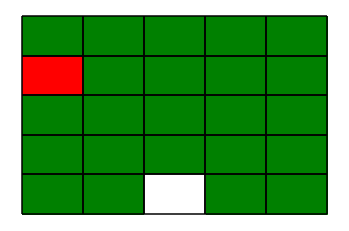

[('^', 3)]
0.13700000000000018
[('<', 1)]
0.039000000000000055
[('v', 3)]
-0.16299999999999984
[('<', 0)]
-1.01
[('>', 1)]
-0.06099999999999994
[('>', 0)]
-1.01
[('<', 2)]
0.08800000000000012
[('>', 3)]
-0.16299999999999984
[('v', 0)]
-1.01
[('<', 3)]
0.13700000000000018
[('^', 0)]
-1.01
[('<', 0)]
-1.01
[('>', 4)]
-0.21399999999999977
[('<', 3)]
0.13700000000000018
[('>', 3)]
-0.16299999999999984
[('^', 1)]
0.039000000000000055
[('<', 4)]
0.18600000000000022
[('<', 0)]
-1.01
[('>', 2)]
-0.11199999999999989
[('v', 0)]
-1.01
[('>', 0)]
-1.01
[('^', 3)]
0.03700000000000017
[('v', 1)]
0.039000000000000055
[('>', 0)]
-1.01
[('<', 2)]
0.039000000000000055
[('v', 1)]
-0.06099999999999994
[('<', 0)]
-1.01
[('<', 0)]
-1.01
[('<', 0)]
-1.01
[('^', 2)]
-0.011999999999999886
[('<', 0)]
-1.01
[('^', 0)]
-1.01
[('>', 2)]
-0.011999999999999886
[('>', 1)]
-0.06099999999999994
[('<', 2)]
0.08800000000000012
[('v', 3)]
61.03799999999999
[('<', 0)]
-1.01
[('>', 3)]
-0.013000000000010914
[('^', 3)]
-0.01

In [15]:
from MazeEnv import MazeEnv

maze = MazeEnv(5, 5)
# for i in range(10):
print("State:", maze.get_state())
maze.draw_maze()
for i in range(100):
    action = maze.random_action()
    maze.show_action(action)
    next_state, reward, done, info  = maze.step(action)
    print(reward)
    # print(reward)
    # print("Action:", action)
    # maze.draw_maze()

In [29]:
x=[1,2,3]
x[::-1]

[3, 2, 1]